In [ ]:
 #importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from prophet import Prophet
import plotly.express as px

In [ ]:
#load the dataset
data = pd.read_csv('/content/internet_usage (1).csv')

In [ ]:
#display summary statistics
print(data.info())
print(data.describe())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Country Name  217 non-null    object
 1   Country Code  217 non-null    object
 2   2000          217 non-null    object
 3   2001          217 non-null    object
 4   2002          217 non-null    object
 5   2003          217 non-null    object
 6   2004          217 non-null    object
 7   2005          217 non-null    object
 8   2006          217 non-null    object
 9   2007          217 non-null    object
 10  2008          217 non-null    object
 11  2009          217 non-null    object
 12  2010          217 non-null    object
 13  2011          217 non-null    object
 14  2012          217 non-null    object
 15  2013          217 non-null    object
 16  2014          217 non-null    object
 17  2015          217 non-null    object
 18  2016          217 non-null    object
 19  2017    

In [ ]:
#find missing values
missing_values = data.isnull().sum()
print("Missing vlues\n",missing_values)

Missing vlues
 Country Name    0
Country Code    0
2000            0
2001            0
2002            0
2003            0
2004            0
2005            0
2006            0
2007            0
2008            0
2009            0
2010            0
2011            0
2012            0
2013            0
2014            0
2015            0
2016            0
2017            0
2018            0
2019            0
2020            0
2021            0
2022            0
2023            0
dtype: int64


In [ ]:
#DATA CLEANING
#handle missing values
# Convert columns to numeric where possible
for col in data.columns[2:]:  # Iterate through columns starting from the third column
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Fill missing values using interpolation
data.iloc[:, 2:] = data.iloc[:, 2:].interpolate(method='linear', axis=0) # Change axis to 0 for interpolation along columns

# Ensure percentages are within valid range
data.iloc[:, 2:] = data.iloc[:, 2:].clip(0, 100)

# Handle missing values in non-year columns
data['Country Name'] = data['Country Name'].fillna(data['Country Name'].mode()[0])
data['Country Code'] = data['Country Code'].fillna(data['Country Code'].mode()[0])

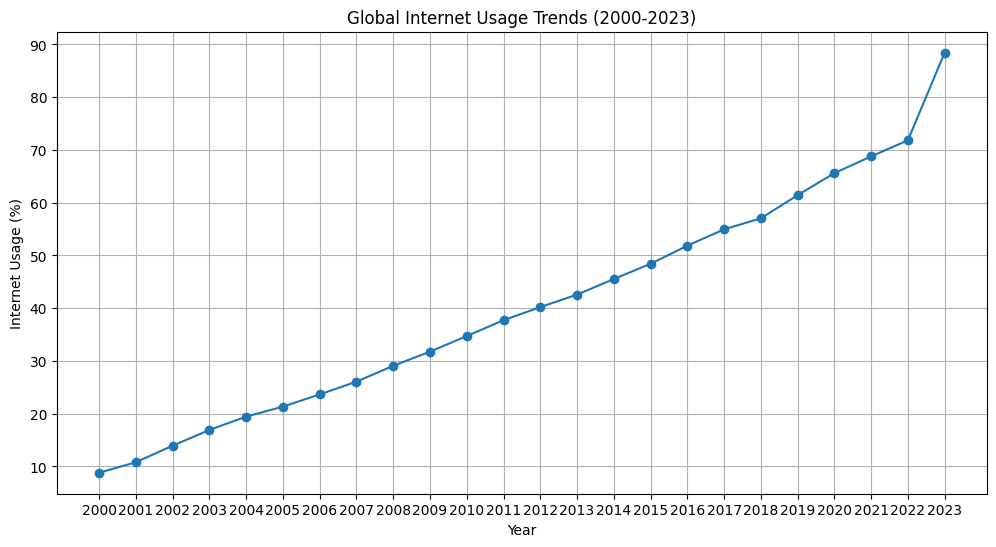

In [ ]:
#step 3:exploratory data analysis
#calculate global avg per year
global_avg_per_year = data.iloc[:, 2:].mean()
#line plot for global avgs
plt.figure(figsize=(12, 6))
# Use the correct variable name 'global_avg_per_year'
plt.plot(global_avg_per_year.index, global_avg_per_year.values, marker='o')
plt.title("Global Internet Usage Trends (2000-2023)")
plt.xlabel("Year")
plt.ylabel("Internet Usage (%)")
plt.grid()
plt.show()

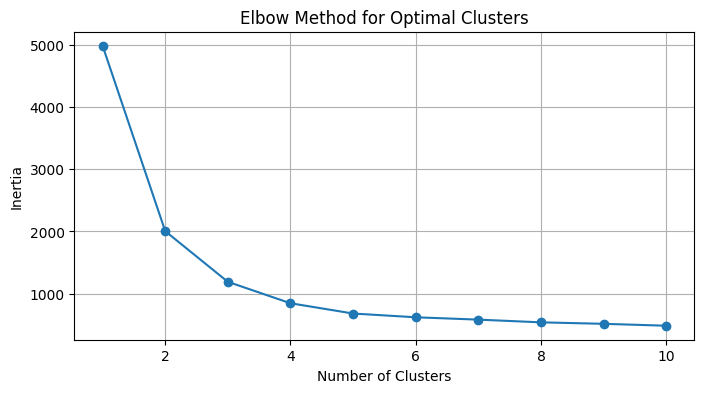

In [ ]:
# Step 5: Clustering Analysis
# Prepare data for clustering
clustering_data = data.iloc[:, 2:-1]  # Ensure relevant year columns are included

# Handle missing values by imputing with the mean
clustering_data = clustering_data.fillna(clustering_data.mean())

scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data)

# Determine optimal clusters using the elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), inertia, marker='o')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid()
plt.show()

# Apply K-Means clustering (e.g., k=4)
kmeans = KMeans(n_clusters=4, random_state=42)
data['Cluster'] = kmeans.fit_predict(scaled_data)

# Visualize clusters using Plotly
fig = px.scatter(data, x='2000', y='2023', color='Cluster',
                 hover_name='Country Name', title="Clustering of Countries by Internet Usage")
fig.show()

<ipython-input-12-cfa51f66c0af>:13: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmph43q_d__/4zylg4pz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph43q_d__/hepq6o4j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31511', 'data', 'fil

Selected country for forecasting: United States


11:03:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning:

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.



NameError: name 'Bangladesh' is not defined

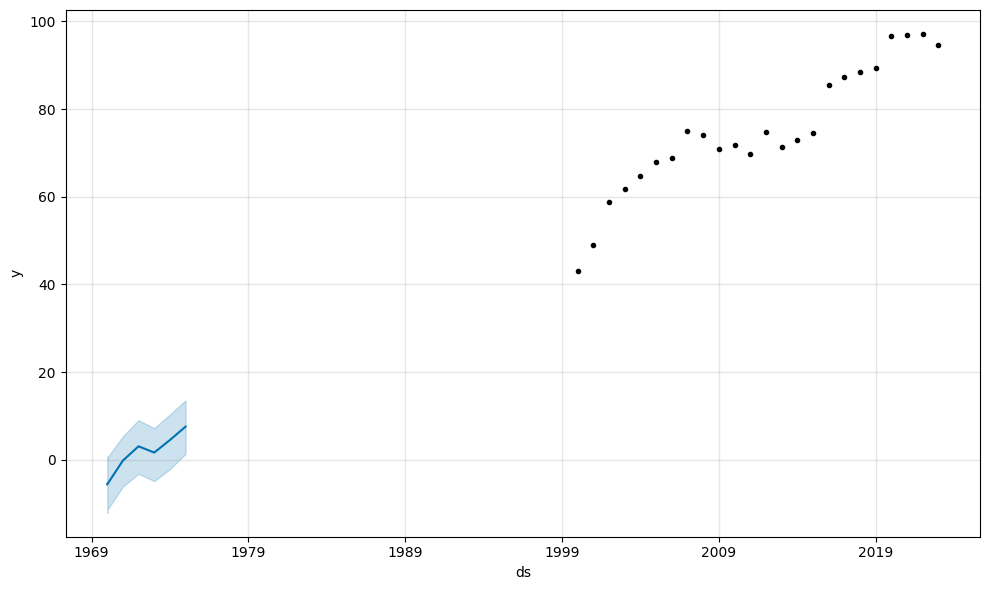

In [ ]:
# Step 6: Time Series Forecasting
# Reshape data for forecasting
forecast_data = data.melt(id_vars=['Country Name', 'Country Code'],
                          var_name='Year', value_name='Usage')

# Filter out non-numeric 'Year' values
forecast_data = forecast_data[forecast_data['Year'].str.isnumeric()]

forecast_data['Year'] = forecast_data['Year'].astype(int)

# Check for countries with sufficient data points
min_data_points = 2
countries_with_data = forecast_data.groupby('Country Name').apply(
    lambda x: x['Usage'].notna().sum()
)
valid_countries = countries_with_data[countries_with_data >= min_data_points].index.tolist()

# Handle case when no country has enough data points
if not valid_countries:
    print("No country has enough data points for forecasting.")
else:
    # Select a country for forecasting
    selected_country = 'United States' if 'United States' in valid_countries else valid_countries[0]
    print(f"Selected country for forecasting: {selected_country}")

    # Filter data for the selected country
    country_data = forecast_data[forecast_data['Country Name'] == selected_country]

    # Ensure rows with valid Usage values
    country_data = country_data[country_data['Usage'].notna()]

    # Prepare data for Prophet
    prophet_data = country_data[['Year', 'Usage']]
    prophet_data.columns = ['ds', 'y']

    # Fit the Prophet model
    prophet_model = Prophet()
    prophet_model.fit(prophet_data)

    # Create future dataframe and forecast
    future = prophet_model.make_future_dataframe(periods=5, freq='Y')
    forecast = prophet_model.predict(future)

    # Plot the forecast
    fig = prophet_model.plot(forecast)
    plt.title(f"Internet Usage Forecast for {selected_country}")
    plt.show()


In [ ]:
import plotly.express as px

latest_year = "2023"
fig = px.choropleth(
    data, locations="Country Code",
    color=latest_year,
    hover_name="Country Name",
    title=f"Global Internet Usage in {latest_year}",
    color_continuous_scale="Blues"
)
fig.show()


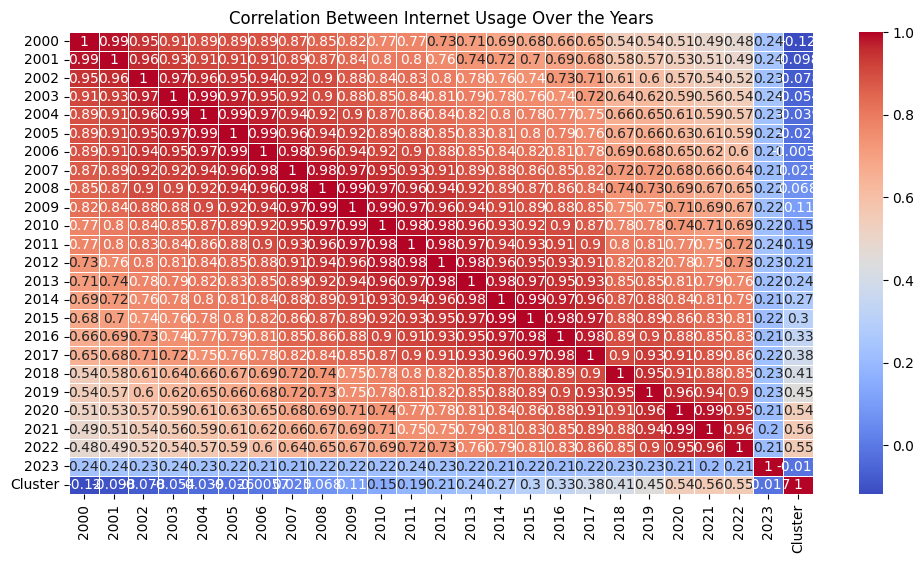

In [ ]:
import seaborn as sns

correlation_matrix = data.iloc[:, 2:].corr()
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Between Internet Usage Over the Years")
plt.show()


Selected country for ARIMA forecasting: United States


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.11/dist-packages/st

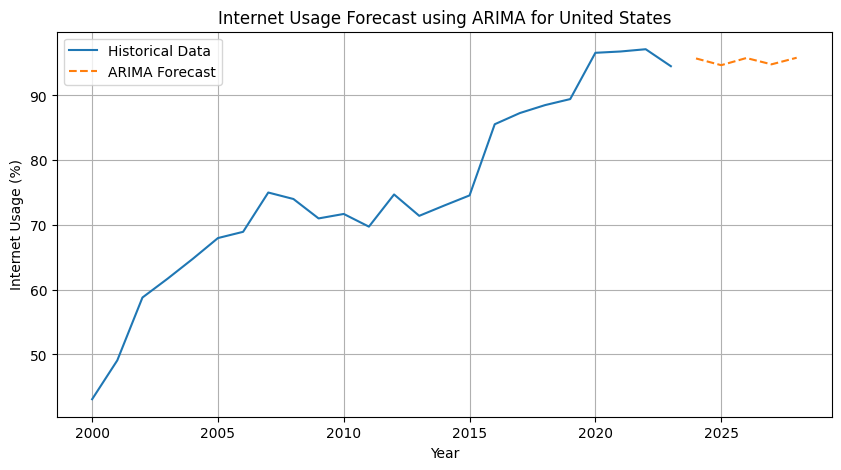

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

if valid_countries:
    selected_country = 'United States' if 'United States' in valid_countries else valid_countries[0]
    print(f"Selected country for ARIMA forecasting: {selected_country}")

    country_data = forecast_data[forecast_data["Country Name"] == selected_country].dropna()

    if len(country_data) > 5:  # Ensure sufficient data points for ARIMA
        # Train ARIMA model
        model = ARIMA(country_data["Usage"], order=(2,1,2))  # Adjust order based on AIC/BIC selection
        model_fit = model.fit()

        # Forecast next 5 years
        forecast_arima = model_fit.forecast(steps=5)
        forecast_years = list(range(country_data["Year"].max() + 1, country_data["Year"].max() + 6))

        # Plot forecast
        plt.figure(figsize=(10,5))
        plt.plot(country_data["Year"], country_data["Usage"], label="Historical Data")
        plt.plot(forecast_years, forecast_arima, label="ARIMA Forecast", linestyle="dashed")
        plt.title(f"Internet Usage Forecast using ARIMA for {selected_country}")
        plt.xlabel("Year")
        plt.ylabel("Internet Usage (%)")
        plt.legend()
        plt.grid()
        plt.show()
    else:
        print("Not enough data points for ARIMA forecasting.")
